# <center> 【Kaggle】Telco Customer Churn 电信用户流失预测案例

## <font face="仿宋">第三部分导读

&emsp;&emsp;<font face="仿宋">在案例的第二部分中，我们详细介绍了常用特征转化方法，其中有些是模型训练之必须，如自然数编码、独热编码，而有些方法则是以提高数据质量为核心、在大多数时候都是作为模型优化的备选方法，如连续变量分箱、数据标准化等。当然，在此之后，我们首先尝试构建一些可解释性较强的模型来进行用户流失预测，即采用逻辑回归和决策树模型来进行预测，并同时详细介绍了两种模型在实战中的调优技巧，在最终模型训练完成后，我们也重点讨论了关于两种可解释性模型建模结果的解释方法。

&emsp;&emsp;<font face="仿宋">从理论上来说，树模型的判别能力是要强于逻辑回归的，但在上一节最后的建模结果中我们发现两个模型的建模并无显著差别，预测准确率都维持在79%-80%之间，这或许说明很多逻辑回归无法正确判别的样本决策树模型也无法判别，据此我们推测，这是一个“入门容易、精通较难”的数据集。当然，如果我们进一步尝试其他“更强”的集成学习算法，如随机森林、XGB、CatBoost等，在当前数据集上的建模结果和逻辑回归也并无太大差异，因此我们亟需通过特征工程方法进一步提升数据集质量，进而提升最终模型效果。

&emsp;&emsp;<font face="仿宋">当然，哪怕是复杂模型在当前数据集上表现出了更好的效果，采用特征工程方法提升数据质量仍是优化建模结果必不可少的部分，正如时下流行的描述那样，“数据质量决定模型上界，而建模过程只是不断逼近这个上界”，特征工程中的一系列提高数据质量的方法、无论是在工业界实践中还是各大顶级竞赛里，都已然成了最为重要的提升模型效果的手段。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gwllgk4wgqj31hr0u0wh4.jpg" alt="image-20211112170651500" style="zoom:15%;" />

&emsp;&emsp;<font face="仿宋">不过，所谓的通过特征工程方法提高数据质量，看似简单但实际操作起来却并不容易。其难点并不在于其中具体操作方法的理解，至少相比机器学习算法原理，特征工程的很多方法并不复杂，特征工程的最大难点在于配合模型与数据进行方法选择、以及各种方法的工程化部署实现。一方面，特征工程方法众多，需要根据实际情况“因地制宜”，但数据的情况千变万化，很多时候需要同时结合数据探索结论、建模人员自身经验以及对各种备选方法的熟悉程度，才能快速制定行之有效的特征工程策略；另一方面，很多特征工程方法不像机器学习算法有现成的库可以直接调用，很多方法、尤其是一些围绕当前数据集的定制方法，需要自己手动实现，而这个过程就对建模人员本身的代码编写能力及工程部署能力提出了更高的要求。总而言之，特征工程是一个实践高度相关的技术，这也是为何课程会在介绍案例的过程中同步介绍特征工程常用方法的原因。

&emsp;&emsp;<font face="仿宋">当然，从宽泛的角度来看，所有围绕数据集的数据调整工作都可以看成是特征工程的一部分，包括此前介绍的缺失值填补、数据编码、特征变换等，这些方法其实都能一定程度提升数据质量，而本节开始，我们将花费一整节的时间来讨论另一类特征工程方法：特征衍生与特征筛选。而该方法通过创建更多特征来提供更多捕捉数据规律的维度，从而提升模型效果。当然特征衍生也是目前公认的最为有效的、能够显著提升数据集质量方法。

# <center>Part 3.特征衍生与特征筛选

&emsp;&emsp;本阶开始我们将重点讨论特征工程中的特征衍生与特征筛选方法，并借此进一步提升模型效果。首先需要将此前的操作中涉及到的第三方库进行统一的导入：

In [1]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *

# re模块相关
import inspect, re

其中telcoFunc是自定义的模块，其内保存了此前自定义的函数和类，后续新增的函数和类也将逐步写入其中，telcoFunc.py文件随课件提供，需要将其放置于当前ipy文件同一文件夹内才能正常导入。

&emsp;&emsp;接下来导入数据并执行Part 1中的数据清洗步骤。

In [2]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [3]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

接下来即可直接带入数据进行特征衍生。

- 特征衍生基本概念与分类

&emsp;&emsp;所谓特征衍生，指的是通过既有数据进行新特征的创建，特征衍生有时也被称为特征创建、特征提取等。总体来看，特征衍生有两类方法，其一是依据数据集特征进行新特征的创建，此时的特征衍生其实是一类无监督的特征衍生，例如把月度费用（'MonthlyCharges'）和总费用（'TotalCharges'）两列相加，创建新的一列；而另外一种情况是将数据集标签情况也纳入进行考虑来创建新的特征，此时特征衍生其实是有监督的特征衍生，如上一小节中介绍的通过决策树的建模结果对连续变量进行分箱（分箱后的列也是创建的新的一列，只是有时我们会将其替换原始列）。在大多数时候特征衍生特指无监督特征衍生，而有监督的特征衍生我们会称其为目标编码。

&emsp;&emsp;而无论是特征衍生还是目标编码，实现的途径都可以分为两种，其一是通过深入的数据背景和业务背景分析，进行人工字段合成，这种方法创建的字段往往具有较强的业务背景与可解释性，同时也会更加精准、有效的提升模型效果，但缺点是效率较慢，需要人工进行分析和筛选，其二则是抛开业务背景，直接通过一些简单暴力的工程化手段批量创建特征，然后从海量特征池中挑选有用的特征带入进行建模，这种方法简单高效，但工程化方法同质化严重，在竞赛时虽是必备手段，但却难以和其他同样采用工程化手段批量创建特征的竞争者拉开差距。因此，在实际应用时，往往是先通过工程化方法批量创建特征提升模型效果，然后再围绕当前建模需求具体问题具体分析，尝试人工创建一些字段来进一步提升模型效果。

&emsp;&emsp;当然，由于我们此前已经进行了一定程度的业务背景分析和数据探索，外加考虑到代码实现难度由易到难的讲解顺序，我们将先讨论关于人工字段合成的方法，然后再介绍工程化批量创建字段的方法。

# <center>Part 3.1 人工字段合成

&emsp;&emsp;所谓人工字段合成，指的是在经过一定程度的数据探索和业务分析后，基于人工判断的特征创建方法，通过该方法创建的特征往往都带有一定的业务背景，并且创建过程所采用的方法不定，很多时候创建的字段也可以作为新的业务指标。当然也正式因为人工字段合成没有固定的流程，很多时候需要有些“灵感”。接下来我们就根据此前两部分的数据探索和业务分析结果，来进行人工字段合成。

&emsp;&emsp;需要重点强调的是，在实际人工合成字段的过程中，找准思路往往比工程实现更难，并且“思路”往往并没有定式，很多时候思路都是和实践经验高度相关的。因此本节中所介绍的人工合成特征的思路，并不是类似算法理论类的“金科玉律”，而更像是一种基于长期实践经验的总结，同时需要强调的是，思路也并非一成不变的，在实际工作或者竞赛中，同学也可以以本节介绍的基本思路作为参考，更多的尝试自己的一些理解和思路，另外，每一种思路也并不是独立存在的，很多时候我们需要从不同的角度切入进行思考，无论如何，一切以最终实践效果为准。

&emsp;&emsp;总的来看人工合成特征的思路有三种，其一是以基本业务作为出发点，用业务经验和常识来辅助特征创建；其二是以数据规律做为出发点，通过数据层面的探索性分析结论作为创建特征的依据；其三则是以建模结果作为出发点，重点分析误分类样本的数据特性，并据此进行新特征的创建。本节我们将先重点介绍前两种思路的实践过程，而在下一小节、即介绍完批量特征创建后再讨论如何根据模型建模结果来创建特征。

## 一、基于业务背景的特征创建

### 1.分析思路

&emsp;&emsp;我们都知道，机器学习算法最终目的是挖掘有效数据规律，而但凡是数据，就有数据背后所描绘的客观事实（回顾课程开始时介绍的数据概念：数据是描述客观物体的状态属性或者运行规律的数字），早在机器学习算法诞生之前，人们更多的是根据历史经验来进行分析，而长期的历史经验就逐渐积累成了所谓的业务经验，尽管很多业务经验无法被量化，但是却可以作为我们进行特征创建的突破口。例如，用户流失其实是一种很常见的业务场景，一般来说影响用户粘性的因素可能包括服务体验、用户习惯、群体偏好、用户注册时长、同质化竞品等等因素，据此，我们可以在当前数据集中新增两个字段来衡量用户粘性，其一是新人用户标识（专门标记最近1-2个月内入网用户）、其二则是用户购买服务数量。

- 新人用户标识

&emsp;&emsp;我们知道，如果用户注册时间较短，则对产品粘性相对较弱，在数据集中tenure字段是描述用户入网时长的字段，而在该字段的所有取值中，考虑到最短续费周期是一个月，因此有一类用户需要重点关注，那就是最近1-2个月内入网用户：这些用户不仅入网时间短，而且在付费周期的规定下，该类用户极有可能在短暂的体验产品服务后在下个月离网，因此我们不妨单独创建一个字段，用来标注tenure字段取值为1的用户。

> 这里需要注意，我们无法通过用户入网时间和签订合约的周期来判断用户当前是否处于离网状态，该问题涉及到数据集统计周期，稍后会深入进行讨论。

- 购买服务数量

&emsp;&emsp;此外，我们还可以计算用户购买的服务数量，一种简单的判断是用户购买的服务越多、用户粘性越大、用户流失的概率越小，我们可以通过简单汇总每位用户所购买的包括增值服务在内的所有服务类别总数作为新的字段，以此来衡量用户粘性。

### 2.new_customer特征创建

&emsp;&emsp;此处创建一个new_customer字段用于表示是否是新人客户，我们将所有tenure取值为1的用户划分为新人用户，该字段是0/1二分类字段，1表示是新人用户。字段创建过程如下。

&emsp;&emsp;首先确定筛选条件:

In [64]:
# 筛选条件
new_customer_con = (tcc['tenure'] == 1)

In [65]:
new_customer_con

0        True
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: tenure, Length: 7043, dtype: bool

然后创建该字段

In [66]:
new_customer = (new_customer_con * 1).values

当然，该字段的加入能否提升模型效果，我们可以简单通过计算该字段与标签之间的相关性来进行检验，如果该字段与标签相关性较强，则大概率加入该字段后模型效果会有所提升，相关性检验可以通过如下方式完成：

In [69]:
# 提取数据集标签
y = tcc['Churn'].values
y

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [70]:
np.corrcoef(new_customer, y)

array([[1.      , 0.247925],
       [0.247925, 1.      ]])

能够发现，新人字段和标签呈现正相关，即新人用户流失概率较大，并且0.24的相关系数在所有相关系数计算结果中属于较大值（具体可回顾Part 1中所有字段和标签的相关系数计算结果），可以考虑带入该字段进行建模。

> 对于该数据集来说，根据整体相关系数计算结果可以推断，相关系数绝对值大于0.2时就属于可用字段。

### 3.new_customer新增字段效果

&emsp;&emsp;接下来我们测试新特征对模型训练的影响。为了方便对比，我们先运行一次不带新特征的模型结果，然后再运行带新特征的模型。在大多数时候新特征在一个模型上验证有效，在其他模型上也会有效，因此为了更快速的检验结果，此处我们仅验证新特征在逻辑回归上的表现，其他模型的验证过程类似。

- 原数据训练结果

&emsp;&emsp;首先在不带入新特征的数据上运行Part 2中逻辑回归模型训练和超参数搜索的“完全体”，根据Part 2的讨论，该过程能够得出在当前数据集中逻辑回归的最好效果，同时根据Part 2中的讨论，在以准确率作为优化指标时，阈值移动并不会实际发生作用，为了加快搜索过程，本节的网格搜索中将移除阈值移动搜索条件，执行过程如下：

In [71]:
# 提取数据集特征
features = tcc.drop(columns=[ID_col, target]).copy()

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=21)

# 检验列是否划分完全
assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = logit_threshold(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga']}, 
    {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# 实例化网格搜索评估器
logistic_search_r1 = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  scoring='accuracy',
                                  n_jobs = 12)

# 输出时间
s = time.time()
logistic_search_r1.fit(X_train, y_train)
print(time.time()-s, "s")

# 计算预测结果
result_df(logistic_search_r1.best_estimator_, X_train, y_train, X_test, y_test)

42.66864991188049 s


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.808925,0.669973,0.563306,0.612026,0.759614
test_eval,0.793658,0.616803,0.547273,0.579961,0.731786


In [72]:
logistic_search_r1.best_params_

{'columntransformer__num': 'passthrough',
 'logit_threshold__C': 0.30000000000000004,
 'logit_threshold__penalty': 'l2',
 'logit_threshold__solver': 'lbfgs'}

In [73]:
logistic_search_r1.best_score_

0.8042596348884381

- 带入new_customer特征进行训练

&emsp;&emsp;然后我们考虑带入新特征进行建模，在相同搜索流程下测试模型最终效果：

In [74]:
new_customer

array([1, 0, 0, ..., 0, 0, 0])

In [75]:
# 添加new_customer列
features['new_customer'] = new_customer.reshape(-1, 1)

In [76]:
# 数据准备
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=21)

# 检验列是否划分完全
category_new = category_cols + ['new_customer']
assert len(category_new) + len(numeric_cols) == X_train.shape[1]

# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_new), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = logit_threshold(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga']}, 
    {'columntransformer__num':num_pre,  'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# 实例化网格搜索评估器
logistic_search = GridSearchCV(estimator = logistic_pipe,
                               param_grid = logistic_param,
                               scoring='accuracy',
                               n_jobs = 12)

# 输出时间
s = time.time()
logistic_search.fit(X_train, y_train)
print(time.time()-s, "s")

# 计算预测结果
result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test)

42.22627019882202 s


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.808114,0.670631,0.555724,0.607794,0.758954
test_eval,0.797918,0.629474,0.543636,0.583415,0.738119


In [77]:
logistic_search.best_score_

0.8054766734279919

&emsp;&emsp;能够发现，模型在网格搜索中验证集准确率的均值由0.8042提升至0.8052，约提升了0.1%，而测试集上的准确率由0.793658提升到0.797918，有约0.3%的效果提升，而该结果也验证了该特征创建的有效性。同时相比训练集单次运行的准确率结果，我们发现网格搜索中验证集的准确率均值更能代表模型当前泛化能力（注意到带入新特征后的模型在训练集上单次运行的准确率反而有所下降，但测试集上准确率却上升了）。

> 一般来说，除了一些“神来之笔”的特征创建，能够在千分位上提升评分的特征创建就算是取得了较好的效果。

&emsp;&emsp;此外，此处需要注意的是，在特征衍生过程中，由于是通过其他特征创建新的特征，因此新老特征之间往往会存在比较强的共线性，为了消除共线性带来的模型效果影响，往往需要带入网格搜索过程来进行模型训练。

In [78]:
logistic_search.best_params_

{'columntransformer__num': 'passthrough',
 'logit_threshold__C': 0.1,
 'logit_threshold__penalty': 'l2',
 'logit_threshold__solver': 'newton-cg'}

> 对于高度共线性的数据集在训练逻辑回归模型时，网格搜索往往能够搜索出一组结构风险权重更大的参数来降低共线性影响、保证模型泛化能力。

&emsp;&emsp;当然，每次重复运行长段代码会略显冗杂，我们可以把上述验证过程封装为一个函数以简化显式代码的数量。

In [5]:
def features_test(new_features,
                  features = features, 
                  labels = labels, 
                  category_cols = category_cols, 
                  numeric_cols = numeric_cols):
    """
    新特征测试函数
    
    :param features: 数据集特征
    :param labels: 数据集标签
    :param new_features: 新增特征
    :param category_cols: 离散列名称
    :param numeric_cols: 连续列名称
    :return: result_df评估指标
    """
    
    # 数据准备
    if type(new_features) == np.ndarray:
        name = 'new_features'
        new_features = pd.Series(new_features, name=name)
    # print(new_features)
    
    features = features.copy()
    category_cols = category_cols.copy()
    numeric_cols = numeric_cols.copy()

    features = pd.concat([features, new_features], axis=1)
    # print(features.columns)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=21)
    
    # 划分连续变量/离散变量
    if type(new_features) == pd.DataFrame:
        for col in new_features:
            if new_features[col].nunique() >= 15:
                numeric_cols.append(col)
            else:
                category_cols.append(col)
    
    else:
        if new_features.nunique() >= 15:
            numeric_cols.append(name)
        else:
            category_cols.append(name)

        
    # print(category_cols)
    # 检验列是否划分完全
    assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

    # 设置转化器流
    logistic_pre = ColumnTransformer([
        ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
        ('num', 'passthrough', numeric_cols)
    ])

    num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

    # 实例化逻辑回归评估器
    logistic_model = logit_threshold(max_iter=int(1e8))

    # 设置机器学习流
    logistic_pipe = make_pipeline(logistic_pre, logistic_model)

    # 设置超参数空间
    logistic_param = [
        {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga']}, 
        {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
    ]

    # 实例化网格搜索评估器
    logistic_search = GridSearchCV(estimator = logistic_pipe,
                                   param_grid = logistic_param,
                                   scoring='accuracy',
                                   n_jobs = 12)

    # 输出时间
    s = time.time()
    logistic_search.fit(X_train, y_train)
    print(time.time()-s, "s")

    # 计算预测结果
    return(logistic_search.best_score_,
           logistic_search.best_params_,
           result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test))

测试函数效果：

In [232]:
# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 创建特征字段
features = tcc.drop(columns=[ID_col, target]).copy()

In [233]:
features_test(new_features = new_customer)

43.75608420372009 s


(0.8054766734279919,
 {'columntransformer__num': 'passthrough',
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l2',
  'logit_threshold__solver': 'newton-cg'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.808114      0.670631         0.555724  0.607794   
 test_eval         0.797918      0.629474         0.543636  0.583415   
 
             roc_auc_score  
 train_eval       0.758954  
 test_eval        0.738119  )

- 模型泛化能力评估

&emsp;&emsp;这里还有一个问题需要深入进行讨论，那就是新特征的有效性到底应该如何评估，也就是如何“证明”带入新特征后构建的模型效果要好于原模型。一般来说模型泛化能力最有力的证明就是经过交叉验证后验证集上的平均得分，即上面的.beat_score结果，而验证集上的准确率提升，其实只能作为模型泛化能力的辅助说明，即如果加入某特征后验证集的平均得分和测试集得分都有所提高，则说明“一个好模型在当前数据集（测试集）上表现出了好的效果”，而如果验证集的平均得分提高了但测试集得分反而下降，则说明“一个好模型未在当前数据集（测试集）上表现出好的效果”。当然，在很多时候测试集本身也并不可知（如竞赛中），我们想强依赖测试集结果来判断模型泛化能力也无从下手（或者适得其反）。

&emsp;&emsp;相信有一定统计学背景的同学肯定从上面一段描述中感受到了似曾相识的感觉，尽管机器学习里面没有置信度、置信区间、假设检验等概念，但哪怕是通过后验的过程，机器学习也希望能够通过某种方法来评估模型泛化能力，而交叉验证时验证集的平均得分就是这么一个基于后验的过程得到的最有力的模型泛化能力的评估指标，并且在大多数时候，验证集的平均得分越高、测试集上的得分也越高，二者大概率保持一致（当然也随着交叉验证的折数越多、二者一致的概率越大）。所以一般来说如果是使用交叉验证，我们完全没必要再设置测试集来进行两阶段测试，完全可以带入全部数据进行建模（更多数据往往会带来更好效果），然后划分更多的交叉验证折数，此处我们仍然保留测试集的原因其实是为了更多的展示交叉验证的平均得分和测试集结果同步变化的特点，以增强学员对交叉验证平均得分的“信任度”，而若是在竞赛时，我们应当将全部有标签的数据带入进行建模并配合交叉验证过程，并在根据验证集平均得分进行参数选择或者特征选择。

### 4.service_num字段创建与效果检验

&emsp;&emsp;接下来进一步创建用于统计用户总共购买服务数量的字段service_num，原始数据集记录了总共'PhoneService'、'MultipleLines'、'InternetService'、'OnlineSecurity'、'OnlineBackup'、'DeviceProtection'、'TechSupport'、'StreamingTV'、'StreamingMovies'总共九项服务的用户购买情况，我们可以通过如下方式汇总每位用户总共购买的服务数量：

In [198]:
service_num = ((tcc['PhoneService'] == 'Yes') * 1
             + (tcc['MultipleLines'] == 'Yes') * 1
             + (tcc['InternetService'] == 'Yes') * 1
             + (tcc['OnlineSecurity'] == 'Yes') * 1 
             + (tcc['OnlineBackup'] == 'Yes') * 1 
             + (tcc['DeviceProtection'] == 'Yes') * 1 
             + (tcc['TechSupport'] == 'Yes') * 1
             + (tcc['StreamingTV'] == 'Yes') * 1
             + (tcc['StreamingMovies'] == 'Yes') * 1
            ).values

In [199]:
service_num

array([1, 3, 3, ..., 1, 2, 6])

In [195]:
features_test(new_features = service_num)

49.24930214881897 s


(0.8046653144016227,
 {'columntransformer__num': StandardScaler(),
  'logit_threshold__C': 0.30000000000000004,
  'logit_threshold__penalty': 'l1',
  'logit_threshold__solver': 'saga'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.807505      0.667877         0.557998  0.608013   
 test_eval         0.797444      0.626033         0.550909  0.586074   
 
             roc_auc_score  
 train_eval       0.757789  
 test_eval        0.737203  )

&emsp;&emsp;能够发现，模型在网格搜索中验证集准确率的均值由0.8042提升至0.8047，约提升了0.05%，而测试集上的准确率由0.793658提升到0.797444，有约0.3%的效果提升。

### 5.组合字段效果

&emsp;&emsp;当然，我们也可以将上述两个字段同时带入数据集测试模型效果，此前定义的features_test函数能够处理DataFrame类型数据，我们只需要将新增的两个特征合成一个新的DataFrame然后带入函数即可。

In [241]:
new_customer

array([1, 0, 0, ..., 0, 0, 0])

In [242]:
service_num

array([1, 3, 3, ..., 1, 2, 6])

In [248]:
new_features = pd.DataFrame({'new_customer': new_customer, 'service_num': service_num})
new_features[:5]

,new_customer,service_num
0,1,1
1,0,3
2,0,3
3,0,3
4,0,1


In [240]:
features_test(new_features = new_features)

49.44947409629822 s


(0.8056795131845842,
 {'columntransformer__num': 'passthrough',
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l2',
  'logit_threshold__solver': 'newton-cg'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.807505      0.669104         0.554966  0.606714   
 test_eval         0.797918      0.630573         0.540000  0.581783   
 
             roc_auc_score  
 train_eval       0.758040  
 test_eval        0.738246  )

带入不同特征对比结果如下：

| 字段说明 | 交叉验证结果 | 交叉验证提升 | 测试集结果 | 测试集提升 | 
| ------ | ------ | ------ | ------ | ------ |
| 原始数据 | 0.8042 | 0 | 0.793658 | 0 |
| new_customer | 0.8054 | 0.0012 | 0.797918 | 0.0042 |
| service_num | 0.8046 | 0.0004 | 0.797444  | 0.0037 |
| 同时带入 | 0.8056 | 0.0014 | 0.797918 | 0.0042 |

&emsp;&emsp;能够发现，新模型在验证集上的得分（0.805679）略高于单独特征的最高得分，也就是单独带入new_customer时的得分（0.8054766）。尽管测试集上评分并没有高于单独带入new_customer时的得分，但按照此前所说，只要验证集上的平均得分提升了就说明模型泛化能力有所提高。

&emsp;&emsp;不过需要知道的是，在大多数情况下，特征的叠加效果都不会超过单独特征提升效果之和，而当新增特征过多时，还有可能造成维度灾难，从而导致模型效果下降，外加带入的数据过多也会导致计算时长增加，因此当创建了许多特征后，需要谨慎筛选带入建模的特征。更多关于特征筛选的方法，我们将在本节结尾进行介绍。

## 二、基于数据分布规律的字段创建

&emsp;&emsp;如果说基于业务经验的字段创建是一种基于通识经验的特征衍生方法，那么基于当前数据分布的字段创建方法，则是更加贴合当前实际情况、基于更深度分析然后再进行的特征创建。在大多数情况下，基于数据具体情况进行的特征衍生也会更加有效，同时衍生出来的特征也可以作为新的业务指标，指导实际业务开展。

- 有效特征

&emsp;&emsp;当然，在具体特征创建和筛选之前，我们也可以就“什么样的特征能更好的帮助模型进行建模结果”进行更进一步探讨。根据此前的分析我们知道，很多时候特征衍生工作并不是为了创造更多的信息，而是更好的去呈现既有信息，那么一般来说，如果我们创建的特征对应的不同类别比例差异越大、则该特征就约有利于帮助模型完成训练（例如创建的某特征取值为1时对应数据标签全部为1或者全部为0）。

> 当然，随着分析的深入，我们还将就此结论进一步添加若干限制条件，如能区分更多的样本，以及相比原始字段提升效果等。

&emsp;&emsp;因此，我们需要从那些本身对标签有较高区分度的特征（如流失率特别大或流失率特别小的特征）入手进行分析，并且在分析的过程中，我们先借助此前采用的堆叠柱状图来进行分析，然后再给出更加严谨的有效特征的评估方法。

### 1.人口统计信息字段探索与特征衍生

&emsp;&emsp;首先我们先围绕用户人口统计属性类字段来展开分析，在Part 1中我们曾通过可视化方式对这类字段的标签取值分布进行了过堆叠柱状图分析，其基本结果如下：

<center><img src="https://i.loli.net/2021/11/22/Wm2NzEbFhswDAQM.png" alt="image-20211122203140386" style="zoom:33%;" />

- 分析思路

&emsp;&emsp;不难发现，在所有三个字段中，老年用户字段'SeniorCitizen'是一个区分度极为明显的字段，经过简单统计分析不难发现，有近半数的老年用户都流失了：

In [7]:
# 老年用户流失比例
tcc[(tcc['SeniorCitizen'] == 1)]['Churn'].mean()

0.4168126094570928

如此少量的人群却有如此高的流失率，我们不妨先从老年字段入手进行分析。当然，一方面，从中我们能够看出该电信运营商提供的产品确实对老年用户不够友好，同时该字段如此高的流失率，也成了我们进一步进行数据探索的突破口。一般来说有响应率较高的字段或者数值异常字段，都可以成为进一步数据探索的突破口。此处我们重点关注的是，在其他关联字段（即用户人口统计信息字段）中，是否有其他某字段对老年用户流失有重要影响，如果有的话，二者字段的组合就能够对用户是否流失进行较好的标记。也就是说，我们这里是希望从老年字段入手，通过和其他关联字段的组合，创建一个新的有效字段。

- 数值验证

&emsp;&emsp;与老年字段同属人口统计信息的字段还有'Dependents'、'Partner'和'gender'三个，并且每个字段都有两个取值水平。我们首先将老年人用户信息单独提取出来：

In [15]:
ts = tcc[tcc['SeniorCitizen'] == 1]
ts.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,1
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95,0


然后和Part 1类似，通过堆叠柱状图来观察其他不同变量的不同取值对用户是否流失的影响情况：

Text(0.5, 1.0, 'Churn by gender')

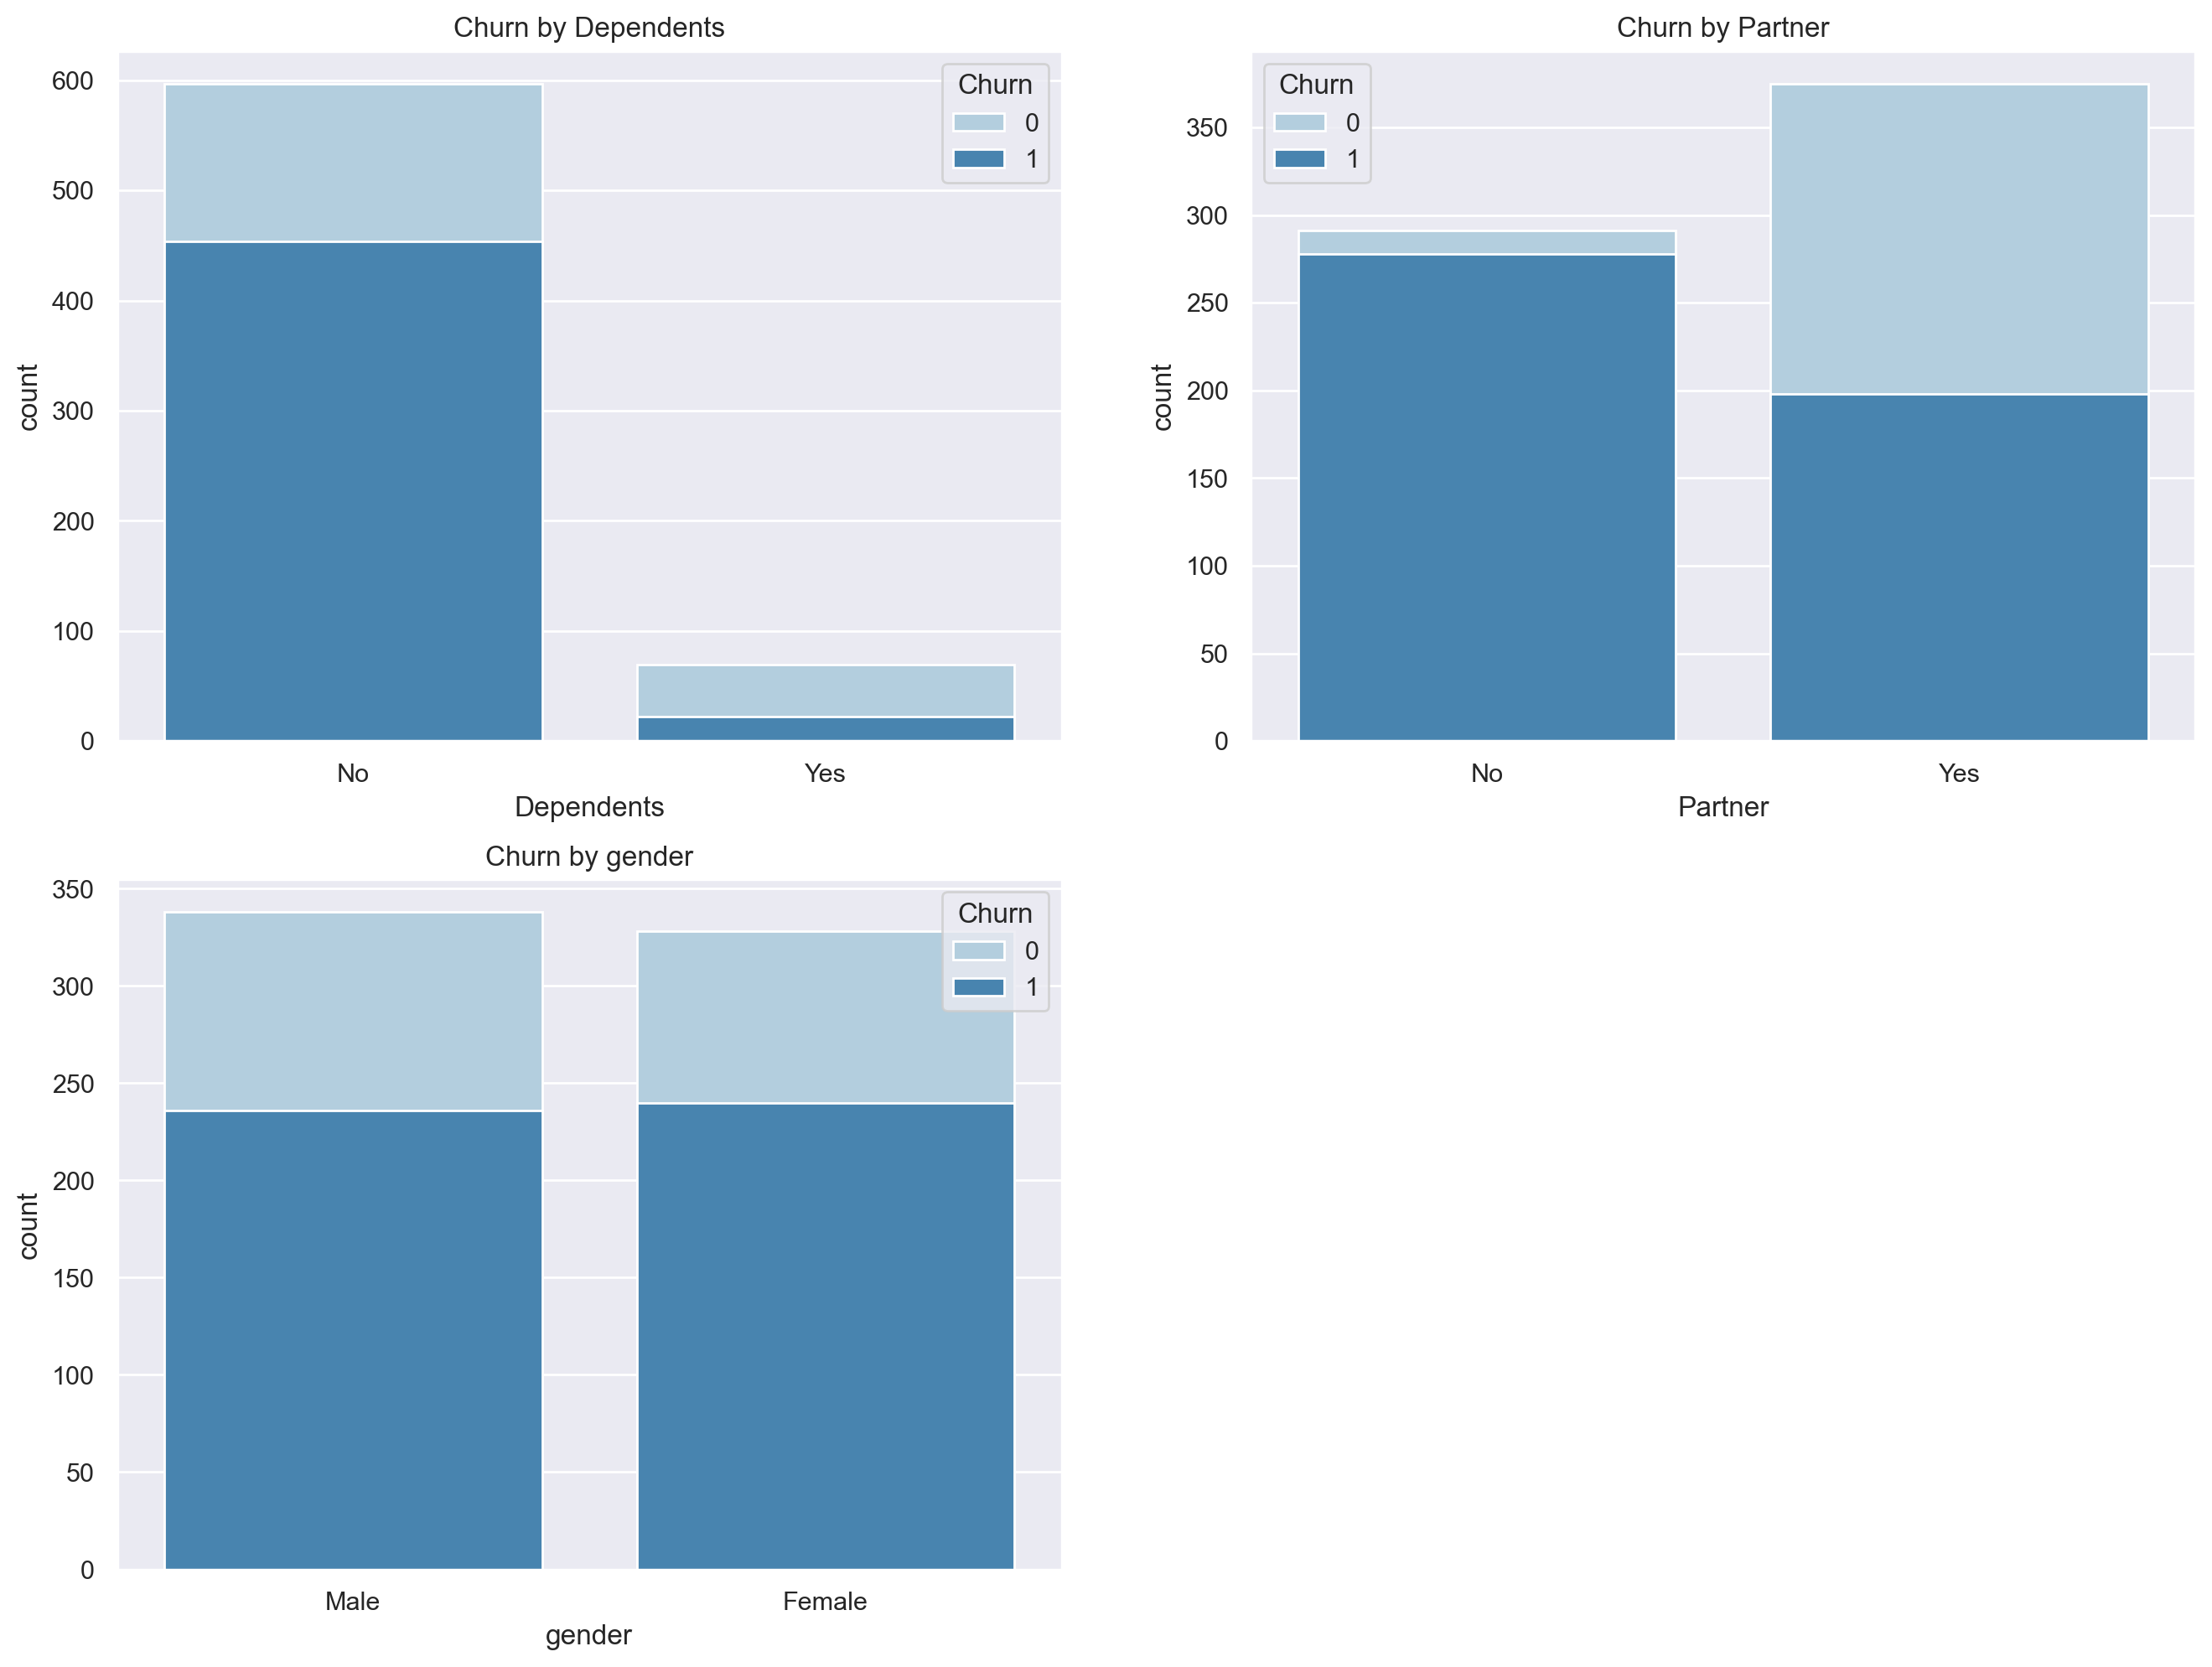

In [23]:
sns.set()
plt.figure(figsize=(16,12), dpi=200)

plt.subplot(221)
sns.countplot(x="Dependents",hue="Churn",data=ts,palette="Blues", dodge=False)
plt.xlabel("Dependents")
plt.title("Churn by Dependents")

plt.subplot(222)
sns.countplot(x="Partner",hue="Churn",data=ts,palette="Blues", dodge=False)
plt.xlabel("Partner")
plt.title("Churn by Partner")

plt.subplot(223)
sns.countplot(x="gender",hue="Churn",data=ts,palette="Blues", dodge=False)
plt.xlabel("gender")
plt.title("Churn by gender")

能够发现，性别字段对于老年用户来说对流失率的交叉影响并不明显，而Dependents和Partner字段对老年用户人群交叉影响较为明显，即流失率在该两个字段的不同取值上差异较大，当然我们重点关注那些流失率较大的交叉影响组合结果，即两个字段取值为No的时候人群基本情况，我们可以通过如下方式统计满足条件的总人数及该人群流失率：

In [33]:
(ts[ts['Partner'] == 'No']['Churn'].mean(),
ts[ts['Partner'] == 'No']['Churn'].shape[0])

(0.48857644991212656, 569)

In [34]:
(ts[ts['Dependents'] == 'No']['Churn'].mean(),
ts[ts['Dependents'] == 'No']['Churn'].shape[0])

(0.4319695528068506, 1051)

假设A类用户为老年且没有伴侣的用户，B类用户为老年且经济不独立的用户，则根据上述统计结果我们发现，两类用户都比单独老年用户流失比例更高，这说明如果我们提取这两类人群的划分能够帮我们更好的标识风险人群，我们可以据此衍生出两个不同的字段，即老年且没有伴侣标识字段（字段A）和老年且不经济独立标识字段（字段B）。同时我们也发现，尽管A类用户比B类用户流失率高5%，A类用户人数只有B类用户的一半，这说明A类人群划分尽管有效，但不一定有很好的普适性，对应字段A对模型建模帮助或许不如字段B。

- WOE计算与IV值检验

&emsp;&emsp;当然，到底哪个字段会对建模更有帮助，最直接的方法就是分别带入进行建模，然后观察最终模型输出结果。但是，如果出于某些情况的考虑（如备选特征过多需要提前筛选、或者单次运行模型时间较长等），我们需要在不带入建模的情况下比较两个变量对模型提升效果优劣的话，也是有方法的，其中最通用同时也是被广泛验证较为有效的检验一个变量预测能力的方式，就是计算IV(information value)值，此处IV值和决策树的IV值同名，但这里的IV并不是依据C4.5中信息熵计算得来，而是一种简单基于样本比例的计算过程，其基本公式如下：

$$IV = \sum^{N}_{i=1}IV_i=\sum^{N}_{i=1}(P_{good}^{(i)}-P_{Bad}^{(i)})*WOE_i=
\sum^{N}_{i=1}(P_{good}^{(i)}-P_{Bad}^{(i)})*ln\frac{P_{Good}^{(i)}}{P_{Bad}^{(i)}}$$

首先，IV值的计算结果是二分类问题中某离散变量的信息价值，或者说该变量对标签取值的影响程度，IV值越大说明该字段对标签取值影响越大、带入该字段能够更有效的帮助模型进行预测。而在上述计算过程中，good/bad只是标签的不同取值，就相当于是1类样本和0类样本，而$i$则表示某特征的不同取值，$P_{Good}$和$P_{Bad}$则是在对应特征某取值下分组汇总后算得出来的1类样本和0类样本占所有1类/0类样本的比例，每个特征的不同取值都可以算得一组$IV_i$，而最终将一个特征内的所有$IV_i$进行求和，即可算出该特征的IV值。以'SeniorCitizen'为例，不同类型用户总数为：

In [18]:
tcc['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

在'SeniorCitizen'取值为1时，划分出的子数据集中不同类型用户总数为：

In [15]:
tcc[tcc['SeniorCitizen'] == 1]['Churn'].value_counts()

0    666
1    476
Name: Churn, dtype: int64

据此我们可以计算$P^{(1)}_{Good}$和$P^{(1)}_{Bad}$，此时$i=1$表示是特征取值为1时划分出的子数据集计算结果，而Good表示1类样本，Bad表示0类样本：

In [20]:
PG1 = tcc[tcc['SeniorCitizen'] == 1]['Churn'].value_counts()[1] / tcc['Churn'].value_counts()[1]
PG1

0.2546816479400749

即'SeniorCitizen'取值为1时子数据集中1类样本的数量占总数据集1类样本数量比例。当然我们也可以继续计算$P^{(1)}_{Bad}$：

In [21]:
PB1 = tcc[tcc['SeniorCitizen'] == 1]['Churn'].value_counts()[0] / tcc['Churn'].value_counts()[0]
PB1

0.12872052570545034

即'SeniorCitizen'取值为1时子数据集中0类样本的数量占总数据集0类样本数量比例。据此我们可以进一步计算$IV_1$:

In [27]:
IV_1 = (PG1-PB1) * np.log(PG1/PB1)
IV_1

0.08595218406217259

类似的，我们可以继续计算$IV_0$，此时i=0表示'SeniorCitizen'取值为1时子数据集的计算结果：

In [28]:
PG0 = tcc[tcc['SeniorCitizen'] == 0]['Churn'].value_counts()[1] / tcc['Churn'].value_counts()[1]
PB0 = tcc[tcc['SeniorCitizen'] == 0]['Churn'].value_counts()[0] / tcc['Churn'].value_counts()[0]
IV_0 = (PG0-PB0) * np.log(PG0/PB0)
IV_0

0.019668998791874313

最终'SeniorCitizen'这列的IV值为：

In [29]:
IV_0 + IV_1

0.1056211828540469

一般来说，IV值越大表示特征越有效，并且一般认为IV值和特征效果有如下对应关系：

| IV值 | 特征效果 |
| ------ | ------ |
| <0.03 | 无效特征 |
| [0.03, 0.09) | 具有较弱判别效果 |
| [0.1, 0.29) | 具有一定的判别效果 |
| [0.3, 0.49) | 具有较好的判别效果 |
| >=0.5 | 具有极强的判别效果 |

但是，需要注意的是，新字段和数据原始特征都能计算IV值，而新字段又是由原始字段生成的，因此在信息量上会和原始字段有些重叠，若是需要通过IV值来判断新字段是否有用，则不能简单看新字段的IV值，而是需要用新字段的IV值和原始字段进行对比，新字段IV值至少要比原始字段IV最小值要大，新字段才是有效字段。接下来我们就将进行验证。

> 更多特征筛选方法，我们将在本节后半段进行讨论

> 除了能够作为特征重要性评估手段外，IV值和WOE计算过程也经常用于连续字段分箱中，尤其常见于评分卡模型。

- 函数封装

&emsp;&emsp;在后续内容中，我们将频繁使用IV值来进行特征重要性评估，此处我们可以先将上述计算过程封装为一个函数，方便后续调用：

In [269]:
def IV(new_features, DataFrame=tcc, target=target):
    count_result = DataFrame[target].value_counts().values
    
    def IV_cal(features_name, target, df_temp):
        IV_l = []
        for i in features_name:
            IV_temp_l = []
            for values in df_temp[i].unique():
                data_temp = df_temp[df_temp[i] == values][target]
                PB, PG = data_temp.value_counts().values / count_result
                IV_temp = (PG-PB) * np.log(PG/PB)
                IV_temp_l.append(IV_temp)
            IV_l.append(np.array(IV_temp_l).sum())
        return(IV_l)
            
    if type(new_features) == np.ndarray:
        features_name = ['new_features']
        new_features = pd.Series(new_features, name=features_name[0])
    elif type(new_features) == pd.Series:
        features_name = [new_features.name]
    else:
        features_name = new_features.columns

    df_temp = pd.concat([new_features, DataFrame], axis=1)
    df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
    IV_l = IV_cal(features_name=features_name, target=target, df_temp=df_temp)

    res = pd.DataFrame(IV_l, columns=['IV'], index=features_name)
    return(res)

In [354]:
IV(tcc[['SeniorCitizen', 'Partner', 'Dependents']])

,IV
SeniorCitizen,0.105621
Partner,0.118729
Dependents,0.155488


&emsp;&emsp;接下来，我们借助上述定义的函数来进行A类（老年且没有伴侣）用户和B类用户（老年且不经济独立）标识字段的IV值计算：

In [336]:
custmer_A = (((tcc['SeniorCitizen'] == 1) & (tcc['Partner'] == 'No')) * 1).values
custmer_B = (((tcc['SeniorCitizen'] == 1) & (tcc['Dependents'] == 'No')) * 1).values

In [337]:
new_features = pd.DataFrame({'custmer_A':custmer_A, 'custmer_B':custmer_B})

In [338]:
IV(new_features)

,IV
custmer_A,0.099502
custmer_B,0.114785


&emsp;&emsp;能够发现，用于创建A字段的两个原始字段的IV值（0.105621、0.118729）都比A字段IV值要高（0.099502），而B字段的IV值（0.114785）则要高于构建该字段的SeniorCitizen字段的IV值（0.105621），据此我们判断B字段是可用的有效字段。

- 效果检验

&emsp;&emsp;接下来我们将上述两个字段分别带入模型测试实际效果：

In [295]:
features_test(new_features = custmer_A)

44.55527067184448 s


(0.8038539553752535,
 {'columntransformer__num': StandardScaler(),
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l1',
  'logit_threshold__solver': 'saga'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.806491      0.670401         0.544352  0.600837   
 test_eval         0.792712      0.621212         0.521818  0.567194   
 
             roc_auc_score  
 train_eval       0.757331  
 test_eval        0.730957  )

In [296]:
features_test(new_features = custmer_B)

42.324854135513306 s


(0.8048681541582152,
 {'columntransformer__num': 'passthrough',
  'logit_threshold__C': 0.30000000000000004,
  'logit_threshold__penalty': 'l2',
  'logit_threshold__solver': 'lbfgs'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.808519      0.668464         0.564064  0.611842   
 test_eval         0.795078      0.618661         0.554545  0.584851   
 
             roc_auc_score  
 train_eval       0.758911  
 test_eval        0.733713  )

能够发现，相比原始结果（best_score=0.8042，测试集准确率为0.793658），字段B能够有效提升模型效果，而字段A则帮助不大，据此我们也能够看出IV值在帮助进行特征筛选时的有效性。

> 同时我们也能够发现，若带入特征不当，则会起到适得其反的效果。

> 另外，上述结果等价于说明通过对经济不独立的老年人进行区分能够提高模型效果，进一步我们可以据此构建一个新的业务指标来知道实际业务的开展，这也是通过算法来创建业务指标的一个示例。

- 特征创建与筛选过程总结

&emsp;&emsp;当然，上述创建字段的过程是一个可以复用的过程，其基本流程如下：

<center><img src="https://i.loli.net/2021/11/22/vMsn9Tjt8hBgwWZ.png" alt="image-20211122201652165" style="zoom:33%;" />

&emsp;&emsp;当然，既然是方法总结，我们还需要通过进一步的尝试来验证该方法的有效性。

### 2.合约周期字段探索与特征衍生

&emsp;&emsp;接下来，我们将上述方法应用到用户账户类字段的分析当中。根据Part 1中的数据探索结果，不难发现月付用户流失率极高：

<center><img src="https://i.loli.net/2021/11/22/AhR39JHz7VfTxPN.png" alt="image-20211122203144392" style="zoom:33%;" />

接下来，我们就从月付费用户入手进行分析，同样，我们先将所有月付费用户单独提取出来：

In [297]:
cm = tcc[tcc['Contract'] == 'Month-to-month']
cm.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


然后同样，我们采用堆叠柱状图来进行分析，在所有的月度付费的用户中，来观察其他用户账户字段字段在不同取值时标签的分布情况：

Text(0.5, 1.0, 'Churn by PaperlessBilling')

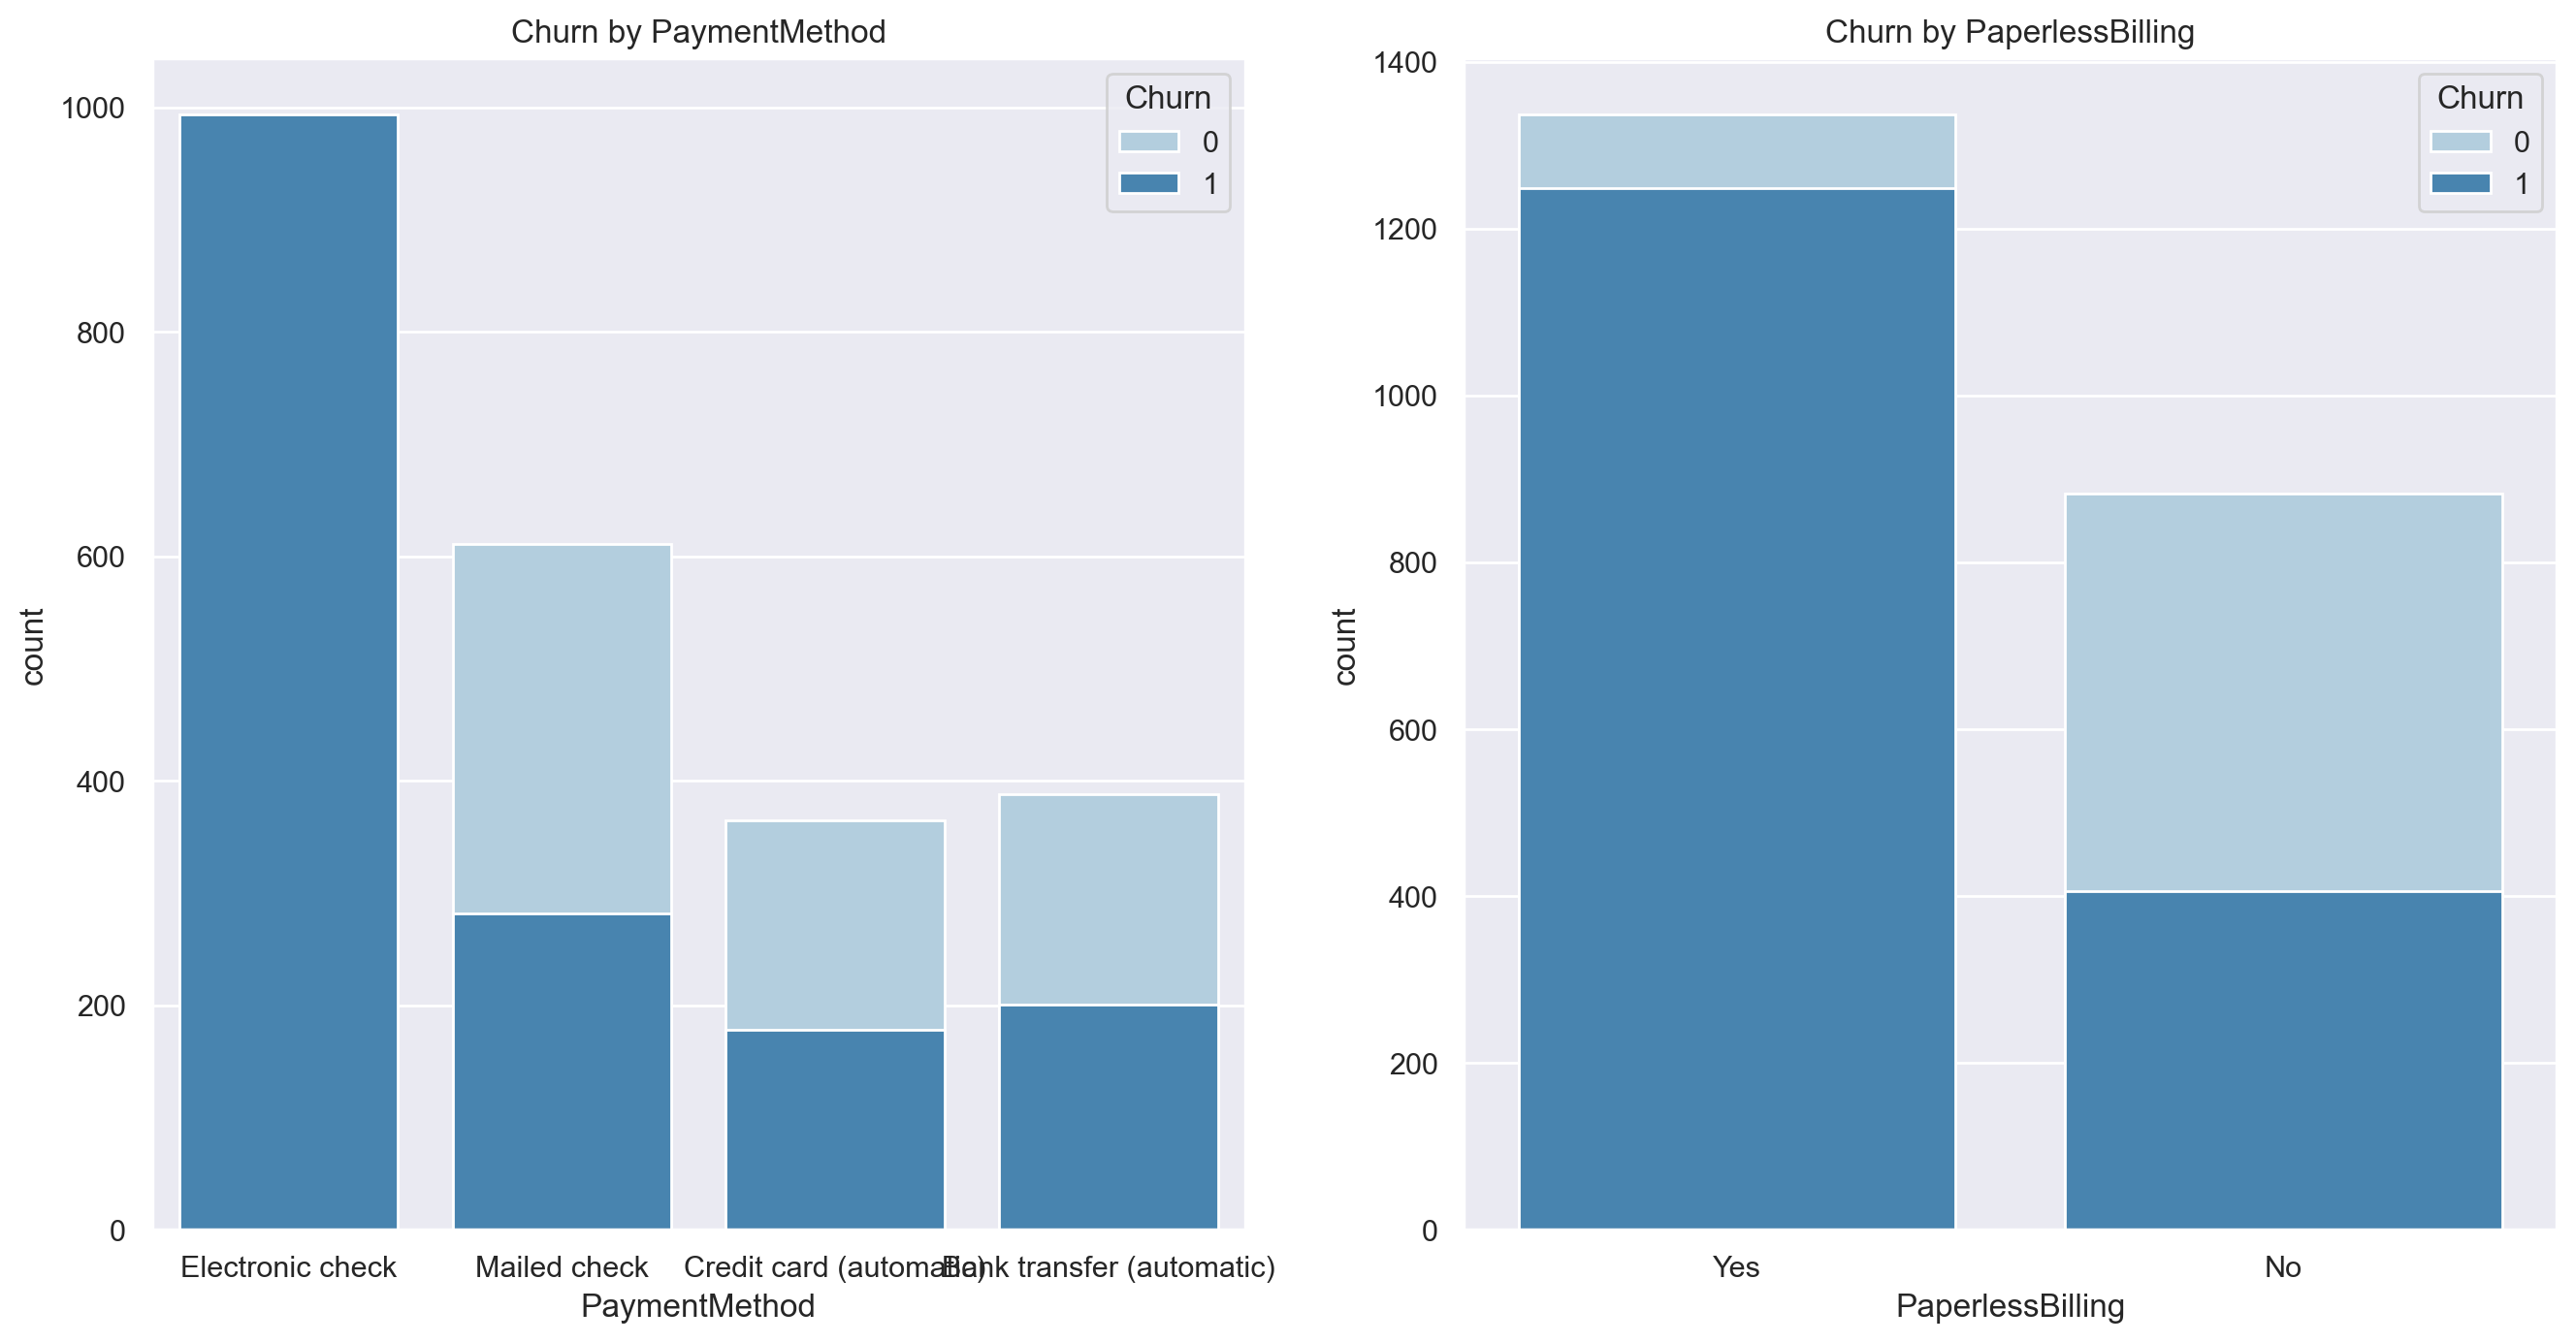

In [357]:
sns.set()
plt.figure(figsize=(16,8), dpi=200)

plt.subplot(121)
sns.countplot(x="PaymentMethod",hue="Churn",data=cm,palette="Blues", dodge=False)
plt.xlabel("PaymentMethod")
plt.title("Churn by PaymentMethod")

plt.subplot(122)
sns.countplot(x="PaperlessBilling",hue="Churn",data=cm,palette="Blues", dodge=False)
plt.xlabel("PaperlessBilling")
plt.title("Churn by PaperlessBilling")

根据图形结果初步判断按月付费同时是通过电子渠道付款的用户，流失率超过半成，当然我们还需要进一步进行计算：

In [358]:
(cm[cm['PaymentMethod'] == 'Electronic check']['Churn'].mean(),
cm[cm['PaymentMethod'] == 'Electronic check']['Churn'].shape[0])

(0.5372972972972972, 1850)

In [359]:
(cm[cm['PaperlessBilling'] == 'Yes']['Churn'].mean(),
cm[cm['PaperlessBilling'] == 'Yes']['Churn'].shape[0])

(0.48298530549110597, 2586)

类似的情况又出现了，按月付费的用户的用户中，电子付费的用户流失率高、但人数较少，而无纸化计费（电子合约）的用户更多、但流失率相对低一些。而根据上述结果，我们可以创建两个复合字段，分别是按月付费且通过电子渠道付费账户（A），以及按月付费且无纸质合约类账户（B），这两个字段是我们根据上述可视化结果判断最有可能提升模型效果的字段（标签分布与原始标签分布差异最大），两类账户标识字段创建过程如下：

In [325]:
account_A = (((tcc['Contract'] == 'Month-to-month') & (tcc['PaymentMethod'] == 'Electronic check')) * 1).values
account_B = (((tcc['Contract'] == 'Month-to-month') & (tcc['PaperlessBilling'] == 'Yes')) * 1).values

接下来验证两个字段的IV值，以及参与创建新字段的原始字段IV值：

In [361]:
# 原始字段IV值
IV(tcc[['Contract', 'PaymentMethod', 'PaperlessBilling']])

,IV
Contract,1.238560
PaymentMethod,0.457109
PaperlessBilling,0.203068


In [362]:
# 新字段IV值
new_features = pd.DataFrame({'account_A':account_A, 'account_B':account_B})
IV(new_features)

,IV
account_A,0.442799
account_B,0.719165


能够发现，A字段的IV值低于参与创建A字段的原始字段的最小值，而B字段的IV值则高于参与创建的原始字段IV值的最小值，因此我们判断B字段将比A字段更加有效。接下来我们分别将两个字段带入模型进行检验，结果如下：

In [313]:
features_test(new_features = account_A)

44.69138741493225 s


(0.8040567951318458,
 {'columntransformer__num': StandardScaler(),
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l1',
  'logit_threshold__solver': 'saga'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.806491      0.670401         0.544352  0.600837   
 test_eval         0.792712      0.621212         0.521818  0.567194   
 
             roc_auc_score  
 train_eval       0.757331  
 test_eval        0.730957  )

In [314]:
features_test(new_features = account_B)

41.55269169807434 s


(0.804868154158215,
 {'columntransformer__num': 'passthrough',
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l2',
  'logit_threshold__solver': 'lbfgs'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.808316      0.667563         0.564822  0.611910   
 test_eval         0.795551      0.620408         0.552727  0.584615   
 
             roc_auc_score  
 train_eval       0.758532  
 test_eval        0.734418  )

建模结果和预期一致，说明方法有效，在此基础上，大家可以进一步尝试其他字段的组合与筛选。

&emsp;&emsp;总的来说，相比基于业务经验的字段创建过程，基于数据探索的字段创建过程更加“有迹可循”，并且上述过程中所涉及到的一些方法，包括交叉衍生离散特征、IV值筛选特征等，也将对后续批量创建字段有所帮助。